In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Set global font to Times New Roman (or closest serif available)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman", "Times", "DejaVu Serif"]

In [13]:
job_to_soc = {
    "Automotive Mechanic Specialized In EV Power": "49-3023.00",  # Automotive Service Technicians and Mechanics
    "Chemical Sprayer": "37-3012.00",  # Pesticide Handlers, Sprayers, and Applicators, Vegetation
    "Co-op Administrative Support": "43-6014.00",  # Secretaries and Administrative Assistants, Except Legal, Medical, and Executive
    "Embassy Administrative Attaché": "43-6011.00",  # Executive Secretaries and Executive Administrative Assistants
    "Livestock Agriculture Technician": "19-4012.00",  # Agricultural Technicians
    "Ministry Program Assistant": "43-4061.00",  # Eligibility Interviewers, Government Programs
    "Seminary Support Staff": "21-2099.00"  # Religious Workers, All Other
}

filtered_df = mca_df[mca_df['Job Title'].isin(job_to_soc.keys())]
filtered_df

,Job Title,Job Sector,Job Subsector,Educational Pathway,HEI with PRC (Professional Regulation Commission) Exam,Some HEI,AIOE,Complementarity,Classification
74,Automotive Mechanic Specialized In EV Power,Manufacturing,Manufacture of batteries and accumulators,Not Higher Education,No,No,-0.876835,0.626389,Protected
162,Chemical Sprayer,"Agriculture, Forestry, and Fishing",Support activities to agriculture and post-har...,Not Higher Education,No,No,-0.540927,0.610889,Protected
244,Co-op Administrative Support,Administrative and Support Service Activities,"Business support service activities, n.e.c.",Higher Education,No,Yes,1.011737,0.521082,Augmentable
340,Embassy Administrative Attaché,Public Administration and Defense; Compulsory ...,Foreign affairs,Higher Education,No,Yes,1.060046,0.500556,Augmentable
651,Livestock Agriculture Technician,"Agriculture, Forestry, and Fishing",Animal production,Higher Education,Yes,No,-0.409552,0.620972,Protected
731,Ministry Program Assistant,Human Health and Social Work Activities,Other social work activities without accommoda...,Higher Education,No,Yes,1.011737,0.521082,Augmentable
970,Seminary Support Staff,Human Health and Social Work Activities,Other social work activities without accommoda...,Higher Education,No,No,0.780637,0.665549,Augmentable


In [7]:
mca_df = pd.read_csv('../3_soc_comple/soc_comple.csv')

def determine_risk(row):
    aioe = row['AIOE']
    comple = row['Complementarity']
    median = 0.5
    #median = mca_df['Complementarity'].median()
    
    if aioe < 0:
        if comple < median:
            return 'Isolated'
        else:
            return 'Protected'
    elif comple < median:
        return 'Displaced'
    elif comple > median:
        return 'Augmentable'
    
mca_df['Classification'] = mca_df.apply(determine_risk, axis=1)

In [8]:
mca_df['Classification'].value_counts(normalize=True)

Classification
Augmentable    0.558099
Protected      0.347711
Isolated       0.059859
Displaced      0.034331
Name: proportion, dtype: float64

# I. How Education Relates to Job Exposure and Augmentability to AI

In [9]:
proportions = mca_df.groupby('Educational Pathway')['Classification'].value_counts(
    normalize=True).reset_index()
pivot_df = proportions.pivot(index='Educational Pathway', columns='Classification', values='proportion')
order = ['Augmentable', 'Protected', 'Isolated', 'Displaced']
(pivot_df[order]).round(2)

Classification,Augmentable,Protected,Isolated,Displaced
Educational Pathway,,,,
Higher Education,0.75,0.17,0.03,0.04
Not Higher Education,0.21,0.66,0.11,0.02


In [5]:
proportions['Classification'].value_counts(normalize=True)

Classification
Augmentable    0.25
Displaced      0.25
Isolated       0.25
Protected      0.25
Name: proportion, dtype: float64

822	Police Officer. -- protected
239	Cook - Isolated
349	English Subject Teacher - augmentable
278	Data Scientist - displaced

In [44]:
mca_df['AIOE'].describe()

count    1129.000000
mean        0.215685
std         0.948354
min        -2.089612
25%        -0.650121
50%         0.383561
75%         1.121408
max         1.505670
Name: AIOE, dtype: float64

In [42]:
mca_df.iloc[278]

Job Title                                                                                    Data Scientist
Job Sector                                                                    Information and Communication
Job Subsector                                             Data processing, hosting and related activitie...
Educational Pathway                                                                        Higher Education
HEI with PRC (Professional Regulation Commission) Exam                                                   No
Some HEI                                                                                                 No
AIOE                                                                                               1.297097
Complementarity                                                                                    0.538611
Classification                                                                                    Displaced
Name: 278, dtype: object

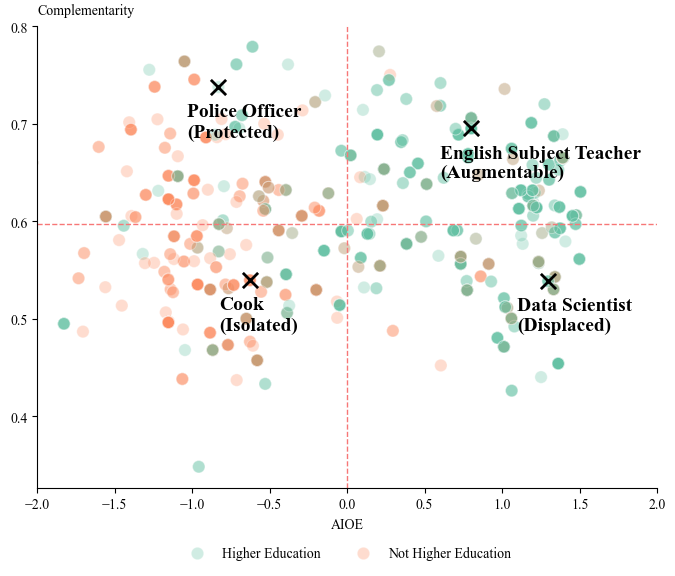

In [69]:
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=mca_df,
    x='AIOE',
    y='Complementarity',
    hue='Educational Pathway',
    palette='Set2',
    alpha=0.3,
    s=80
)

# Representative jobs (manually chosen)
rep_jobs = {
    "Protected":  {"idx": 822, "title": "Police Officer"},
    "Isolated":  {"idx": 239, "title": "Cook"},
    "Augmentable": {"idx": 349, "title": "English Subject Teacher"},
    "Displaced": {"idx": 278, "title": "Data Scientist"}
}

# Add chosen representative jobs
for c, job in rep_jobs.items():
    row = mca_df.loc[job["idx"]]
    plt.scatter(row['AIOE'], row['Complementarity'],
                marker='x', color='black', s=120, linewidths=2)
    plt.text(row['AIOE']-0.2, row['Complementarity']-0.05,
             f"{job['title']}\n({c})", fontsize=14, color='black',
             fontweight='bold')
    
plt.legend(
    loc="upper center",       # place above or below plot
    bbox_to_anchor=(0.5, -0.1), # shift below the axes
    ncol=2,                   # number of columns
    frameon=False             # remove legend box outline
)

# Axes limits and lines
plt.xlim(-2, 2)
#plt.ylim(-3, 3)
plt.axvline(x=0, color="#f77777", linestyle='--', linewidth=1)
plt.axhline(y=mca_df['Complementarity'].median(), color='#f77777', linestyle='--', linewidth=1)

# Labels
plt.xlabel('AIOE')
plt.ylabel('Complementarity', rotation=0, ha='left')
plt.gca().yaxis.set_label_coords(0, 1.02)

# Remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Title
#plt.title('AIOE to Complementarity for Filipino Jobs by Educational Pathway\n\n')

plt.savefig('../figures/aioe_comple.png', dpi=300, bbox_inches='tight')

plt.show()

# II. How Sectors Relates to Job Exposure and Augmentability to AI

In [70]:
pivot_df

Classification,Augmentable,Protected,Isolated,Displaced
Job Sector,,,,
Other Service Activities,0.062500,0.687500,0.250000,0.000000
Financial and Insurance Activities,0.100000,0.000000,0.000000,0.900000
Accommodation and Food Service Activities,0.104478,0.149254,0.522388,0.223881
Construction,0.112245,0.489796,0.275510,0.122449
Manufacturing,0.140940,0.187919,0.496644,0.174497
Transportation and Storage,0.142857,0.357143,0.321429,0.178571
Wholesale and Retail Trade; Repair of Motor Vehicles and Motorcycles,0.181818,0.000000,0.090909,0.727273
"Electricity, Gas, Steam and Air Conditioning Supply",0.217391,0.652174,0.086957,0.043478
Information and Communication,0.221154,0.048077,0.009615,0.721154


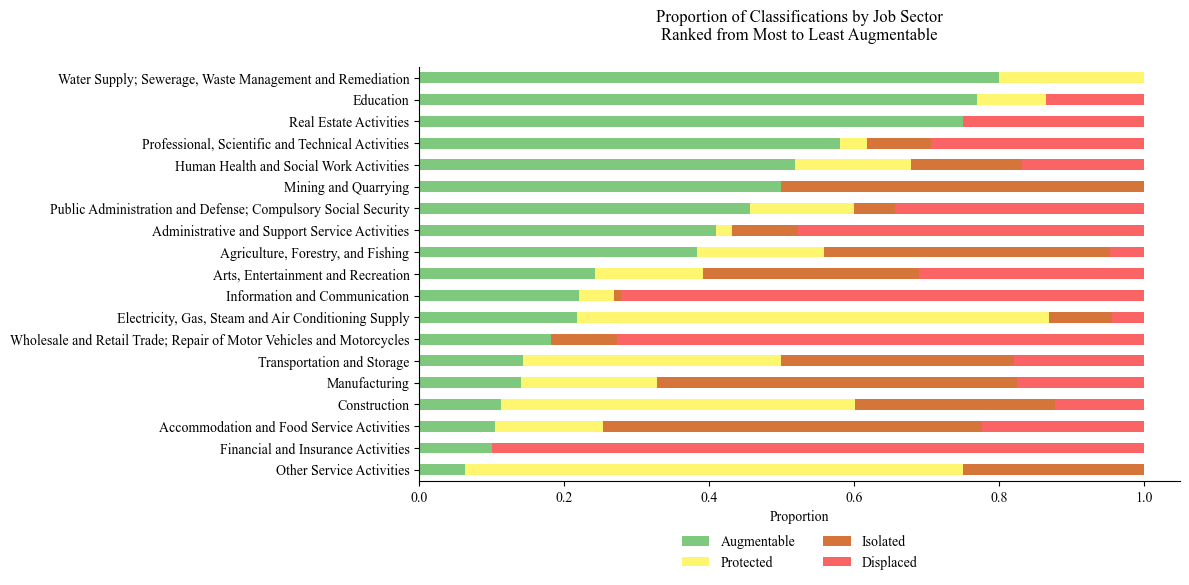

In [71]:
order = ['Augmentable', 'Protected', 'Isolated', 'Displaced']

# Get proportions
proportions = mca_df.groupby('Job Sector')['Classification'] \
                    .value_counts(normalize=True) \
                    .reset_index()

# Get the proportions
proportions = mca_df.groupby('Job Sector')['Classification'].value_counts(
    normalize=True).reset_index()
pivot_df = proportions.pivot(index='Job Sector', columns='Classification', values='proportion')

# Make sure the columns are in the desired order
pivot_df = pivot_df[order]
pivot_df.fillna(0, inplace=True)
pivot_df.sort_values(by=['Augmentable'], ascending=[True], inplace=True)

# Plot stacked bar chart
pivot_df.plot(kind='barh', 
              stacked=True, 
              figsize=(12,6), 
              color=['#7fc97f', "#fdf66e", "#d67539" , "#fb6464" ],
              #color=["#fdf66e",'#7fc97f',"#fb7164"]
              )

# pretty graph pls
plt.xlabel('Proportion')
plt.ylabel('')
plt.title('Proportion of Classifications by Job Sector\nRanked from Most to Least Augmentable\n')
plt.legend(
    loc="upper center",       # place above or below plot
    bbox_to_anchor=(0.5, -0.1), # shift below the axes
    ncol=2,                   # number of columns
    frameon=False             # remove legend box outline
)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

We will now develop a metric to summarize the risk of replacement at the occupation level to AI. This is called the C-AIOE, formally defined as:
$$\text{C-AIOE}_i = \text{AIOE}_i \cdot (1 - (\theta_i - \theta_{\text{MIN}})),$$

where $i$ indexes the job, $\theta_i$ is complementarity to AI, and $\theta_{\text{MIN}}$ is minimum value of $\theta_i$ across all occupations. Overall, jobs with higher C-AIOE because of higher AIOE or lower complementarity are more likely to face AI replacement. 

In [72]:
min_comple = mca_df['Complementarity'].min()
factor = 1 - (mca_df['Complementarity'] - min_comple)
mca_df['C-AIOE'] = mca_df['AIOE'] * factor

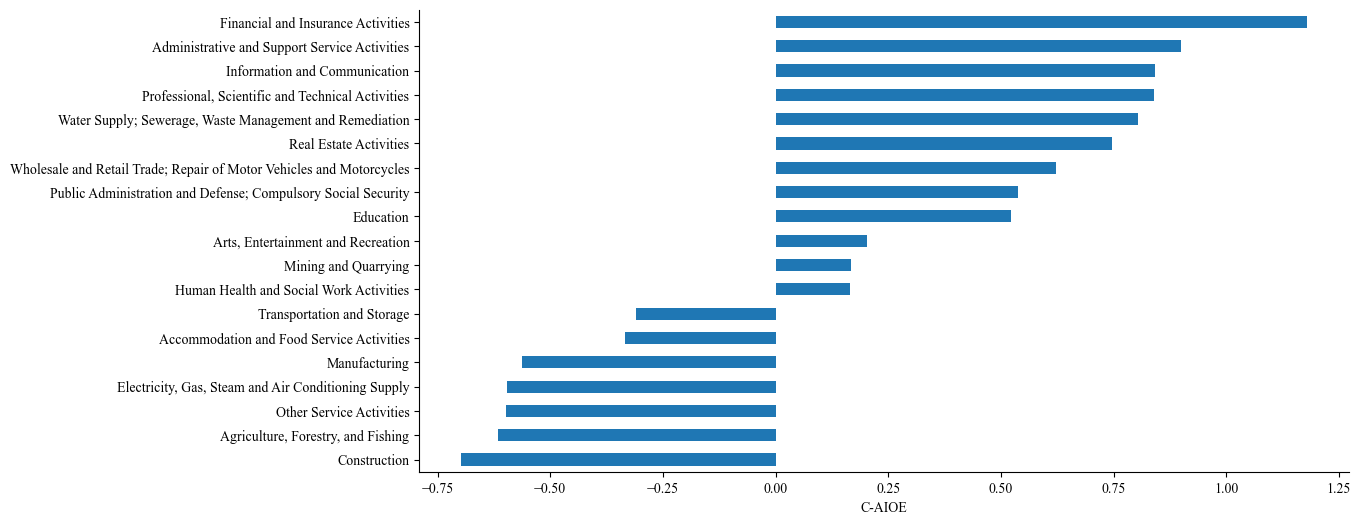

In [73]:
plt.figure(figsize=(12, 6))
mca_df.groupby('Job Sector')['C-AIOE'].median().sort_values().plot(kind='barh')

# pretty graph pls
plt.xlabel('C-AIOE')
plt.ylabel('')
#plt.title('Job Sectors Ranked Most Likely\nAutomated by AI (Based on C-AIOE)\n')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig('../figures/sector_caioe.png', dpi=300, bbox_inches='tight')

plt.show()
